In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
import Bio
from lib import DihedralAdherence
import os
from lib.constants import AMINO_ACID_CODES
from Bio import PDB
from Bio.PDB import Superimposer
from Bio.Align import PairwiseAligner
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
da = DihedralAdherence(proteins[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                      mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
UniProt ID: Q48658


In [7]:

def compute_lddt(xray_fn, pred_fn):
    INCLUSION_RADIUS = 15 # Angstroms
    THRESHOLDS = [0.5, 1, 2, 4] # Angstroms

    parser = PDB.PDBParser(QUIET=True)
    xray_structure = parser.get_structure('', xray_fn)
    pred_structure = parser.get_structure('', pred_fn)
    

    # A is reference
    chainA = next(iter((xray_structure[0].get_chains())))
    chainB = next(iter((pred_structure[0].get_chains())))

    # align
    residuesA = ''.join([AMINO_ACID_CODES.get(r.resname, 'X') for r in chainA.get_residues()])
    residuesB = ''.join([AMINO_ACID_CODES.get(r.resname, 'X') for r in chainB.get_residues()])

    aligner = PairwiseAligner()
    aligner.mode = 'global'
    alignments =  aligner.align(residuesA, residuesB)
    aligned = alignments[0].aligned

    atomsA = list(chainA.get_atoms())
    atomsB = list(chainB.get_atoms())

    atomsA = []
    atomsB = []
    residuesA = list(chainA.get_residues())
    residuesB = list(chainB.get_residues())
    for i,((t1,t2),(q1,q2)) in enumerate(zip(*aligned)):
        for j, (residueA, residueB) in enumerate(zip(residuesA[t1:t2], residuesB[q1:q2])):
            if residueA.resname != residueB.resname:
                print(f'{residueA.resname} != {residueB.resname}')
                continue
            try:
                atomsA.append(residueA['CA'].coord)
                atomsB.append(residueB['CA'].coord)
            except KeyError:
                print(f'No CA atom for {residueA.resname} or {residueB.resname}')
        
        if i < aligned.shape[1] - 1:
            if aligned[0,i][1] != aligned[0,i+1][0]:
                for k in range(aligned[0,i][1], aligned[0,i+1][0]+1):
                    try:
                        atomsA.append(residuesA[k]['CA'].coord)
                        atomsB.append(np.full(3, np.nan))
                    except KeyError:
                        continue
        elif aligned[0,i][1] != len(residuesA):
            for k in range(aligned[0,i][1], len(residuesA)):
                try:
                    atomsA.append(residuesA[k]['CA'].coord)
                    atomsB.append(np.full(3, np.nan))
                except KeyError:
                    continue

    atomsA = np.array(atomsA)
    atomsB = np.array(atomsB)

    # 273x1x3 - 273x3 = 273x273x3
    # norm(x) = sqrt(sum(x**2, axis=-1))
    pairwise_dists_A = np.linalg.norm(atomsA[:, None] - atomsA, axis=-1)
    pairwise_dists_B = np.linalg.norm(atomsB[:, None] - atomsB, axis=-1)

    # Compute lddt
    lddt = []
    local_atoms_mask = (pairwise_dists_A <= INCLUSION_RADIUS)
    n_local_atoms = local_atoms_mask.sum()
    dist_diff = np.abs(pairwise_dists_A - pairwise_dists_B)
    dist_diff[~local_atoms_mask] = np.inf   # Exclude atoms outside of the inclusion radius
    dist_diff[np.isnan(dist_diff)] = np.inf # Missing atoms are not preserved
    lddt = np.mean([(dist_diff < thresh).sum() / n_local_atoms for thresh in THRESHOLDS])
    
    return lddt

lddt = compute_lddt(da.xray_fn, da.predictions_dir / da.alphafold_id)

In [13]:
da.results[da.results.Model == protein_id] 

,Model,GR#,GDT_TS,NP_P,RANK,Z-M1-GDT,Z-MA-GDT,GDT_HA,GDC_SC,GDC_ALL,...,TMscore,Dali(raw),FlexE,QSE,CAD_SS,MolPrb_clash,MolPrb_rotout,MolPrb_ramout,MolPrb_ramfv,lddt
312,T1024TS337_5,337s,55.88,100.0,311,NaN,0.28,32.48,15.84,28.03,...,0.84,3879.9,4.28,35.88,0.28,146.53,4.4,1.97,94.58,NaN


In [35]:
for protein in proteins:
    da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, 
                           mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cuda')
    da.load_results_da()
    da.results['lddt'] = np.nan
    for protein_id in da.protein_ids:
        lddt = compute_lddt(da.xray_fn, da.predictions_dir / protein_id)
        da.results.loc[da.results.Model == protein_id, 'lddt'] = lddt
        gdt = da.results.loc[da.results.Model == protein_id, 'GDT_TS'].values[0]
        print(f'{protein_id} lddt: {lddt:.02f}', f'gdt: {gdt}')
    da.results.to_csv(da.outdir / 'results-lddt.csv', index=False)

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
UniProt ID: Q48658
T1024TS337_5 lddt: 0.65 gdt: 55.88
T1024TS367_4 lddt: 0.75 gdt: 61.0
T1024TS170_3 lddt: 0.25 gdt: 10.1
T1024TS378_4 lddt: 0.59 gdt: 43.29
T1024TS198_3 lddt: 0.65 gdt: 47.19
T1024TS259_5 lddt: 0.61 gdt: 46.23
T1024TS278_3 lddt: 0.72 gdt: 55.95
T1024TS409_1 lddt: 0.78 gdt: 60.55
T1024TS337_1 lddt: 0.68 gdt: 59.66
T1024TS042_1 lddt: 0.76 gdt: 61.45
T1024TS081_5 lddt: 0.59 gdt: 42.71
T1024TS187_4 lddt: 0.75 gdt: 62.08
T1024TS063_4 lddt: 0.45 gdt: 29.67
T1024TS192_2 lddt: 0.68 gdt: 58.63
T1024TS138_2 lddt: 0.72 gdt: 55.95
T1024TS341_1 lddt: 0.67 gdt: 48.27
T1024TS428_3 lddt: 0.71 gdt: 55.88
T1024TS075_5 lddt: 0.65 gdt: 48.21
T1024TS334_3 lddt: 0.77 gdt: 61.7
T1024TS005_1 lddt: 0.79 gdt: 60.61
T1024TS071_3 lddt: 0.74 gdt: 60.61
T1024TS138_1 lddt: 0.72 gdt: 56.71
T1024TS226_4 lddt: 0.75 gdt: 64.64
T1024TS487_4 lddt: 0.76 gdt: 59.08
T1024TS050_1 lddt: 0.66 gdt: 48.21
T

In [50]:
da.grouped_preds.merge(da.results[['Model', 'lddt']], left_on='protein_id', right_on='Model', suffixes=('', '_r')).drop('Model_r', axis=1)

,protein_id,da,da_na,Model,GDT_TS,log_da,target,lddt
0,T1024TS004_1,30.266066,0.072139,T1024TS004_1,34.14,1.480956,T1024,0.478541
1,T1024TS004_2,30.189927,0.072139,T1024TS004_2,34.14,1.479862,T1024,0.478564
2,T1024TS004_3,30.229983,0.072139,T1024TS004_3,34.08,1.480438,T1024,0.475111
3,T1024TS004_4,30.654444,0.072139,T1024TS004_4,34.34,1.486493,T1024,0.486165
4,T1024TS004_5,30.583299,0.072139,T1024TS004_5,34.34,1.485484,T1024,0.486142
...,...,...,...,...,...,...,...,...
473,T1024TS498_1,16.460785,0.072139,T1024TS498_1,55.56,1.216451,T1024,0.776140
474,T1024TS498_2,13.037734,0.072139,T1024TS498_2,62.08,1.115202,T1024,0.808306
475,T1024TS498_3,13.770827,0.072139,T1024TS498_3,61.96,1.138960,T1024,0.803207
476,T1024TS498_4,14.460857,0.072139,T1024TS498_4,61.64,1.160194,T1024,0.800287


In [66]:
from scipy.stats import pearsonr, linregress

In [68]:
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
results = []
for protein in proteins:
    # protein = proteins[1]
    da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, 
                            mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cuda')
    da.load_results_da()
    da.filter_nas(0.8)
    da.results = pd.read_csv(da.outdir / 'results-lddt.csv')
    da.grouped_preds = da.grouped_preds.merge(da.results[['Model', 'lddt']], left_on='protein_id', right_on='Model', suffixes=('', '_r')).drop('Model_r', axis=1)

    n_preds = da.grouped_preds_da.shape[0]
    regr = linregress(da.grouped_preds.log_da, da.grouped_preds.lddt)
    rsquared = regr.rvalue**2
    corr, pval = pearsonr(da.grouped_preds.log_da, da.grouped_preds.lddt)

    results.append((protein, rsquared, corr, n_preds))

results = pd.DataFrame(results, columns=['protein', 'rsquared', 'pearsonr', 'n_preds'])
results.loc[len(results)] = ['Mean', results.rsquared.mean(), results.pearsonr.mean(), results.n_preds.mean()]
results.to_markdown('thisresult.md',index=False)

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
UniProt ID: Q48658
Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
UniProt ID: Q8DWZ6
Initializing T1030-D2 ...
Results already exist
Casp ID: T1030-D2 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
UniProt ID: Q8DWZ6
Initializing T1024-D1 ...
Results already exist
Casp ID: T1024-D1 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
UniProt ID: Q48658
Initializing T1032-D1 ...
Results already exist
Casp ID: T1032-D1 	PDB: 6n64
Structure exists: 'pdb/pdb6n64.ent' 
UniProt ID: Q6P5D8
Initializing T1053-D1 ...
Results already exist
Casp ID: T1053-D1 	PDB: 7m7a
Structure exists: 'pdb/pdb7m7a.ent' 
UniProt ID: Q5ZRA8
Initializing T1027-D1 ...
Results already exist
Casp ID: T1027-D1 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 
UniProt ID: Q9BLZ2
Initializing T1029-D1 ...
Results already exist
Casp ID: T1029-D1 	PDB: 6uf2
Stru

In [74]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
proteins = ['T1038', 'T1030-D2', 'T1024-D1', 'T1053-D1', 'T1057-D1', 'T1058-D1', 'T1058-D2'] # good (af >85 gdt)
proteins = ['T1030-D2', 'T1024-D1', 'T1053-D1', 'T1057-D1', 'T1058-D1', 'T1058-D2'] # good (af >85 gdt)
# proteins = ['T1024', 'T1091', 'T1030', 'T1032-D1', 'T1027-D1', 'T1030-D1', 'T1096', 'T1029-D1'] # bad (af <85 gdt)
# proteins = ['T1096', 'T1029-D1'] # bad (af < 50 gdt)
preds = []
for protein in proteins:
    da = DihedralAdherence(
        protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='ml', quantile=1,
        weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cuda'
    )
    da.load_results_da()
    da.filter_nas(.8)
    da.results = pd.read_csv(da.outdir / 'results-lddt.csv')
    da.grouped_preds = da.grouped_preds.merge(da.results[['Model', 'lddt']], left_on='protein_id', right_on='Model', suffixes=('', '_r')).drop('Model_r', axis=1)
    preds.append(da.grouped_preds)

preds = pd.concat(preds)

Initializing T1030-D2 ...
Results already exist
Casp ID: T1030-D2 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 


UniProt ID: Q8DWZ6
Initializing T1024-D1 ...
Results already exist
Casp ID: T1024-D1 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
UniProt ID: Q48658
Initializing T1053-D1 ...
Results already exist
Casp ID: T1053-D1 	PDB: 7m7a
Structure exists: 'pdb/pdb7m7a.ent' 
UniProt ID: Q5ZRA8
Initializing T1057-D1 ...
Results already exist
Casp ID: T1057-D1 	PDB: 7m6b
Structure exists: 'pdb/pdb7m6b.ent' 
UniProt ID: B9MNH4
Initializing T1058-D1 ...
Results already exist
Casp ID: T1058-D1 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
UniProt ID: Q9I117
Initializing T1058-D2 ...
Results already exist
Casp ID: T1058-D2 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
UniProt ID: Q9I117


0.13004920987784213 PearsonRResult(statistic=-0.36062336291183644, pvalue=1.0459450102235545e-72)
Slope: -0.31175218118407283, Intercept: 0.8331185986524425


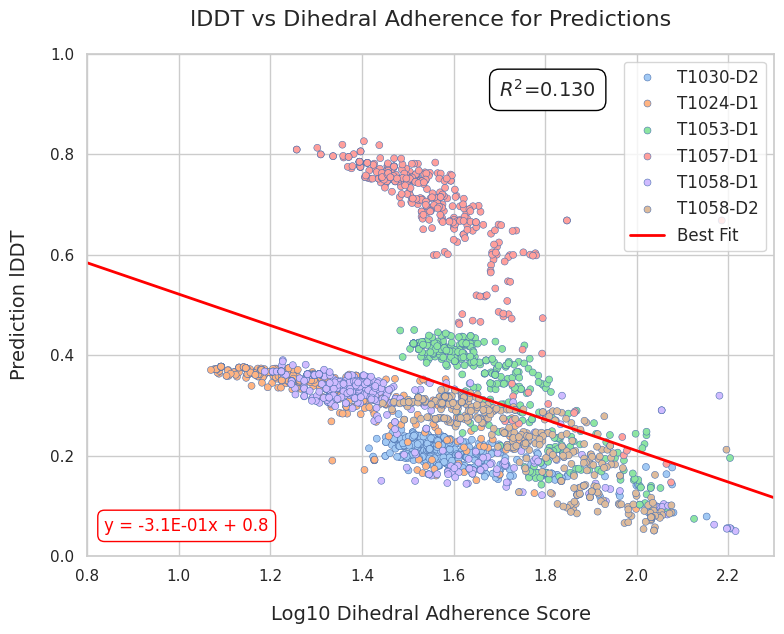

In [75]:
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(8, 6.5))
df = preds.dropna(subset=['da', 'lddt']).reset_index(drop=True)

df['da'] = np.log10(df['da'])
df = df[~df.Model.str.contains('427')]

regr = linregress(df.da, df.lddt)
corr = pearsonr(df['da'], df['lddt'])
print(regr.rvalue**2, corr)
print(f'Slope: {regr.slope}, Intercept: {regr.intercept}')
# sns.kdeplot(data=df, x='da', y='lddt', ax=ax, fill=True, bw_method=0.1)
sns.scatterplot(data=df, x='da', y='lddt', ax=ax, marker='o', s=25, edgecolor='b', legend=True, hue='target', palette='pastel')
# sns.regplot(data=df.reset_index(drop=True), x='da', y='lddt', ax=ax, scatter=False, color='red')
ax.plot(
    np.linspace(0.8, 2.3, 100), 
    regr.intercept + regr.slope * np.linspace(0.8, 2.3, 100), 
    color='red', lw=2, label='Best Fit'
)
ax.set_xlabel('Log10 Dihedral Adherence Score', fontsize=14, labelpad=15)
ax.set_ylabel('Prediction lDDT', fontsize=14, labelpad=15)
ax.set_title(r'lDDT vs Dihedral Adherence for Predictions', fontsize=16, pad=20)
ax.text(0.6, 0.95, r'$R^2$='+f'{regr.rvalue**2:.3f}', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))
if regr.intercept > 0:
    s = f'y = {regr.slope:.1E}x + {regr.intercept:.1f}'
else:
    s = f'y = {regr.slope:.1E}x - {-regr.intercept:.1f}'
ax.text(.025,.05, s, transform=ax.transAxes, fontsize=12, color='red',
        bbox=dict(boxstyle='round,pad=0.4', edgecolor='red', facecolor='white'))
ax.set_xlim(.8, 2.3)
ax.set_ylim(0, 1)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()
sns.reset_defaults()